In [1]:
from sklearn.datasets import fetch_california_housing 
data = fetch_california_housing()
print(data.feature_names) 
X, y = data.data, data.target
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split 
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().reshape(-1, 1)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

In [4]:
training_data = HousingDataset(X_train, y_train)
test_data = HousingDataset(X_test, y_test)

train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)


In [5]:
class HousingNet(torch.nn.Module):
    def __init__(self, n_features):
        super(HousingNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_features, 64)
        self.fc2 = torch.nn.Linear(64, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x)) 
        x = self.fc4(x)
        return x

In [6]:
housing_net = HousingNet(X.shape[1]).to('cuda')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(housing_net.parameters(), lr=1e-4)

In [7]:
# number of parameters in the model
num_params = sum(p.numel() for p in housing_net.parameters() if p.requires_grad)
num_params

33729

In [8]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
train_history = [] 
# training loop
for epoch in range(50):
    housing_net.train()
    mse = 0
    with tqdm.tqdm(train_loader, unit="batch") as bar:
        for X, y in bar:
            X = X.to('cuda')
            y = y.to('cuda')
            y_pred = housing_net(X)
            loss = loss_fn(y_pred, y)
            mse += loss.item()
            mse /= len(train_loader)
            train_history.append(mse)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())

    # evaluate on test set
    housing_net.eval()
    with torch.no_grad():
        mse = 0
        for X, y in test_loader:
            X = X.to('cuda')
            y = y.to('cuda')
            y_pred = housing_net(X)
            mse += loss_fn(y_pred, y).item()
        mse /= len(test_loader)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(housing_net.state_dict())

# load the best weights
housing_net.load_state_dict(best_weights)       

100%|██████████| 903/903 [00:02<00:00, 385.96batch/s, loss=0.186]


<All keys matched successfully>

MSE: 0.57
RMSE: 0.75


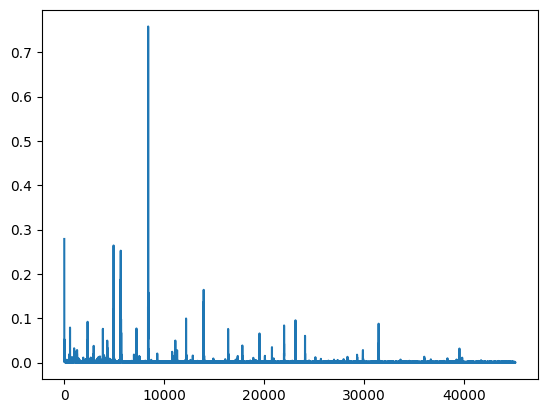

In [9]:
import matplotlib.pyplot as plt
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(train_history)
plt.show()

1.857 [1.3558881]


Text(0, 0.5, 'Predictions')

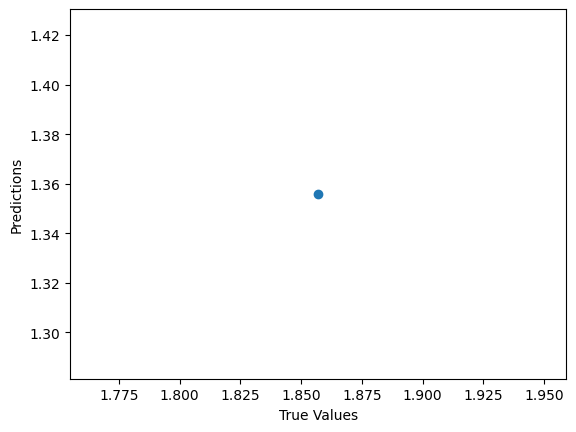

In [10]:
pred = housing_net(torch.from_numpy(X_test[0]).float().to('cuda'))
pred = pred.cpu().detach().numpy()
plt.scatter(y_test[0], pred)
print(y_test[0], pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
# plt.axis('equal')
# plt.xlim(plt.xlim())
# plt.ylim(plt.ylim())
# plt.plot([-100, 100], [-100, 100])
# plt.show()